<a href="https://colab.research.google.com/github/Fibonacci1664/Pix2Pix/blob/main/MyPix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTS**

In [4]:
import tensorflow as tf

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model

print(tf.__version__)

2.9.2


# **HELPER FUNCTION TO CALCULATE THE RECEPTIVE FIELD**

In [2]:
# example of calculating the receptive field for the PatchGAN

# calculate the effective receptive field size
def receptive_field(output_size, kernel_size, stride_size):
    return (output_size - 1) * stride_size + kernel_size

# output layer 1x1 pixel with 4x4 kernel and 1x1 stride
rf = receptive_field(1, 4, 1)
print(rf)
# second last layer with 4x4 kernel and 1x1 stride
rf = receptive_field(rf, 4, 1)
print(rf)
# 3 PatchGAN layers with 4x4 kernel and 2x2 stride
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)

4
7
16
34
70


# **PATCH GAN DISCRIMINATOR MODEL**

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 6)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 batch_normalization_3 (BatchNo  (None, 16, 16, 512)  2048       ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 16, 16, 512)  0           ['batch_normalization_3[0][0]']  
                                                                                                  
 conv2d_5 (Conv2D)              (None, 16, 16, 1)    8193        ['leaky_re_lu_4[0][0]']          
                                                                                                  
 activation (Activation)        (None, 16, 16, 1)    0           ['conv2d_5[0][0]']               
                                                                                                  
Total params: 6,968,257
Trainable params: 6,965,441
Non-trainable params: 2,816
_____________________________

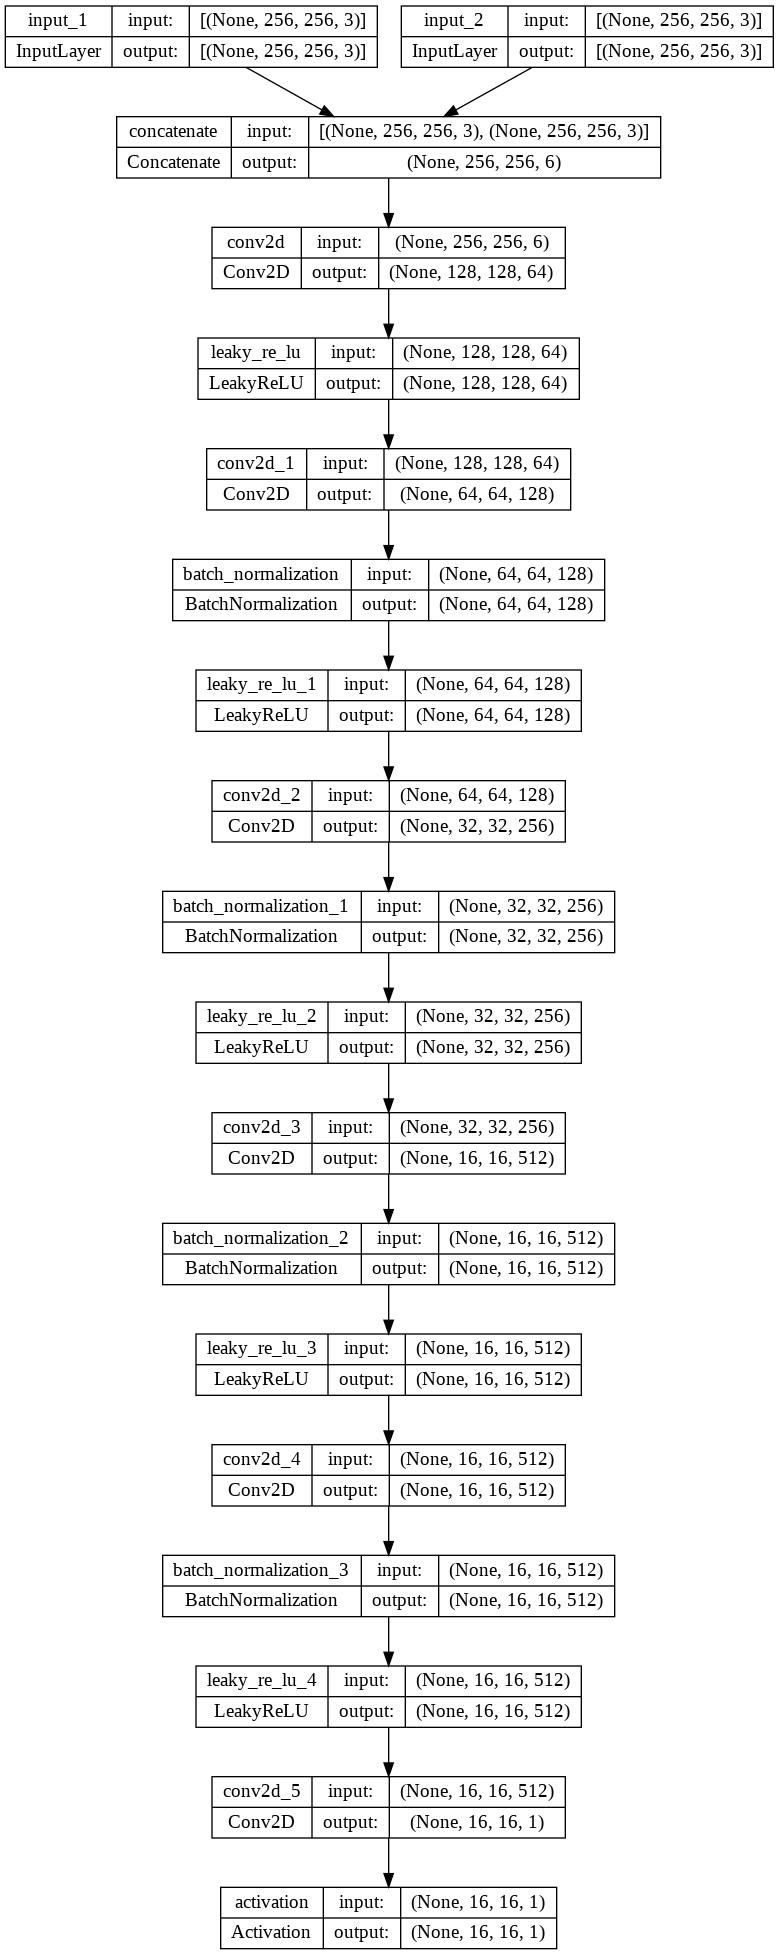

In [5]:
# example of defining a 70x70 patchgan discriminator model
# functional API

# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define image shape
image_shape = (256,256,3)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)